In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
# === 参数配置 ===
data_folder = '5min_smoothed_data/'
valid_outcome_data = 'valid_patients_outcome.csv'
seq_length = 808 #1139 # 固定填充长度
batch_size = 32
epochs = 100
latent_dim = 10
temperature = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# === 1. 加载数据和标签（添加统计信息） ===
def load_eeg_data_with_labels(data_folder, valid_outcome_data, seq_length):
    """
    加载EEG信号数据及其对应的标签.
    返回信号 (NumPy 数组) 和标签列表.
    """
    # 加载标签
    outcome_data = pd.read_csv(valid_outcome_data)
    label_map = outcome_data.set_index('pat_ID')['outcome'].to_dict()

    signals = []
    labels = []

    # 遍历文件夹中的数据文件
    file_list = sorted([f for f in os.listdir(data_folder) if f.endswith('.csv')])
    for filename in file_list:
        patient_id = filename.split('.')[0]  # 文件名的前缀作为患者ID
        label = label_map.get(patient_id, None)
        if label is None:
            continue  # 如果找不到对应标签，跳过该文件

        # 加载信号
        file_path = os.path.join(data_folder, filename)
        data = pd.read_csv(file_path)
        if 'spike hz' not in data.columns:
            continue  # 如果文件中没有 'spike hz' 列，跳过

        signal = data['spike hz'].values
        # 如果信号长度小于 12，跳过该文件
        if len(signal) < 12:
            print(f"Skipping {filename} due to insufficient length ({len(signal)})")
            continue

        # 填充或截断信号
        if len(signal) < seq_length:
            signal = np.pad(signal, (0, seq_length - len(signal)), 'constant', constant_values=-1)
        else:
            signal = signal[:seq_length]

        signals.append(signal)
        labels.append(1 if label == 'Good Outcome' else 0)

    signals = np.array(signals)
    labels = np.array(labels)

    # 打印 Good Outcome 和 Bad Outcome 的数量
    good_count = np.sum(labels == 1)
    bad_count = np.sum(labels == 0)
    print(f"Loaded {len(signals)} samples: {good_count} Good Outcome, {bad_count} Bad Outcome")

    return signals, labels

# === 2. 构造对比样本对（添加对比对统计） ===
class ContrastiveDataset(Dataset):
    def __init__(self, signals, labels):
        """
        构造对比学习数据集.
        :param signals: EEG信号数组
        :param labels: 对应的标签 (0 或 1)
        """
        self.signals = signals
        self.labels = labels

        # 统计 Good Outcome 和 Bad Outcome 的样本数量
        self.good_count = np.sum(labels == 1)
        self.bad_count = np.sum(labels == 0)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        anchor_signal = self.signals[idx]
        anchor_label = self.labels[idx]

        # 找到一个正样本对（相同类别）
        pos_idx = np.random.choice(np.where(self.labels == anchor_label)[0])
        positive_signal = self.signals[pos_idx]

        # 找到一个负样本对（不同类别）
        neg_idx = np.random.choice(np.where(self.labels != anchor_label)[0])
        negative_signal = self.signals[neg_idx]

        # 打印每次生成的样本对信息
        #print(f"Anchor Index: {idx}, Positive Index: {pos_idx}, Negative Index: {neg_idx}")

        return (
            torch.tensor(anchor_signal, dtype=torch.float32).unsqueeze(0),
            torch.tensor(positive_signal, dtype=torch.float32).unsqueeze(0),
            torch.tensor(negative_signal, dtype=torch.float32).unsqueeze(0),
            torch.tensor(anchor_label, dtype=torch.float32),
        )
# === 3. 对比学习模型 ===
class ContrastiveEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ContrastiveEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * seq_length, latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)
    

# === 4. 对比损失函数 ===
class NTXentLoss(nn.Module):
    def __init__(self, temperature):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        计算对比损失，基于余弦相似度.
        """
        # 计算相似度
        pos_sim = F.cosine_similarity(anchor, positive, dim=-1)
        neg_sim = F.cosine_similarity(anchor, negative, dim=-1)

        # 对比损失
        loss = -torch.log(torch.exp(pos_sim / self.temperature) /
                          (torch.exp(pos_sim / self.temperature) + torch.exp(neg_sim / self.temperature)))
        return loss.mean()


# === 5. 训练和测试 ===
def train_with_visualization(model, dataloader, optimizer, criterion, epochs):
    """
    带有进度条和训练曲线可视化的训练函数.
    """
    model.train()
    train_losses = []

    # 创建进度条
    with tqdm(total=epochs, desc="Training Progress") as pbar:
        for epoch in range(epochs):
            total_loss = 0.0
            for anchor, positive, negative, _ in dataloader:
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)

                # 前向传播
                anchor_embed = model(anchor)
                positive_embed = model(positive)
                negative_embed = model(negative)

                # 计算损失
                loss = criterion(anchor_embed, positive_embed, negative_embed)

                # 反向传播和优化
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # 平均损失
            epoch_loss = total_loss / len(dataloader)
            train_losses.append(epoch_loss)

            # 更新进度条
            pbar.set_postfix({"Epoch Loss": f"{epoch_loss:.4f}"})
            pbar.update(1)

    # 绘制训练曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# === 6. 提取特征 ===
def extract_features(model, dataloader):
    """
    使用训练好的对比学习模型提取嵌入特征.
    :param model: 训练好的对比学习模型
    :param dataloader: 数据加载器
    :return: 提取的嵌入特征和对应的标签
    """
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for anchor, _, _, label in dataloader:
            anchor = anchor.to(device)
            label = label.cpu().numpy()

            # 提取特征
            embed = model(anchor).cpu().numpy()
            features.append(embed)
            labels.append(label)

    # 将所有特征和标签拼接起来
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels


# === 7. 分类任务 ===
def classify_with_svm(X_train, y_train, X_test, y_test):
    """
    使用 SVM 分类器进行分类任务.
    :param X_train: 训练集特征
    :param y_train: 训练集标签
    :param X_test: 测试集特征
    :param y_test: 测试集标签
    """
    # 定义 SVM 分类器
    svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
    svm_model.fit(X_train, y_train)

    # 预测
    y_pred = svm_model.predict(X_test)

    # 打印分类结果
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


def classify_with_xgboost(X_train, y_train, X_test, y_test):
    """
    使用 XGBoost 分类器进行分类任务.
    :param X_train: 训练集特征
    :param y_train: 训练集标签
    :param X_test: 测试集特征
    :param y_test: 测试集标签
    """
    # 定义 XGBoost 分类器
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # 预测
    y_pred = xgb_model.predict(X_test)

    # 打印分类结果
    accuracy = accuracy_score(y_test, y_pred)
    print(f"XGBoost Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Skipping ICARE_0055.csv due to insufficient length (2)
Skipping ICARE_0550.csv due to insufficient length (4)
Skipping ICARE_0579.csv due to insufficient length (8)
Skipping ICARE_0687.csv due to insufficient length (8)
Skipping ICARE_0793.csv due to insufficient length (1)
Loaded 293 samples: 51 Good Outcome, 242 Bad Outcome
Loaded signals shape: (293, 808), Labels shape: (293,)


Training Progress: 100%|███| 100/100 [06:56<00:00,  4.16s/it, Epoch Loss=0.0189]


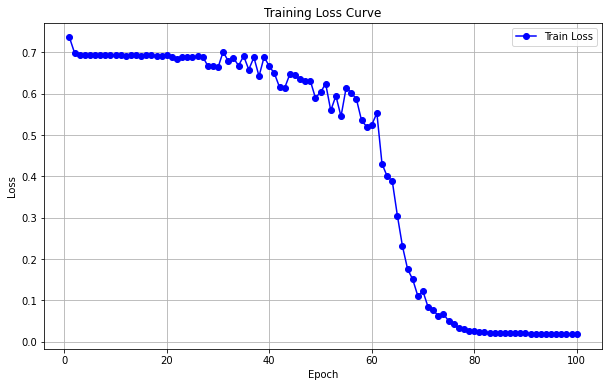

In [6]:
# === 8. 主流程 ===

from sklearn.model_selection import train_test_split

# 加载数据和标签
signals, labels = load_eeg_data_with_labels(data_folder, valid_outcome_data, seq_length)

# 确保加载的数据存在
print(f"Loaded signals shape: {signals.shape}, Labels shape: {labels.shape}")

# 划分训练集和测试集
signals_train, signals_test, labels_train, labels_test = train_test_split(
    signals, labels, test_size=0.3, stratify=labels, random_state=42
)

# 构造训练集和测试集的数据加载器
train_dataset = ContrastiveDataset(signals_train, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ContrastiveDataset(signals_test, labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 初始化模型、损失函数和优化器
model = ContrastiveEncoder(latent_dim).to(device)
criterion = NTXentLoss(temperature)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练模型（只在训练集上训练）

train_losses = train_with_visualization(model, train_dataloader, optimizer, criterion, epochs)



In [7]:
# 使用训练好的模型在训练集和测试集上提取嵌入
features_train, labels_train = extract_features(model, train_dataloader)
features_test, labels_test = extract_features(model, test_dataloader)

# 确保打印提取特征的信息
print(f"Extracted Train Features Shape: {features_train.shape}, Train Labels Shape: {labels_train.shape}")
print(f"Extracted Test Features Shape: {features_test.shape}, Test Labels Shape: {labels_test.shape}")

# 使用 SVM 进行分类
print("\n=== SVM Classification ===")
classify_with_svm(features_train, labels_train, features_test, labels_test)

# 使用 XGBoost 进行分类
print("\n=== XGBoost Classification ===")
classify_with_xgboost(features_train, labels_train, features_test, labels_test)

Extracted Train Features Shape: (205, 10), Train Labels Shape: (205,)
Extracted Test Features Shape: (88, 10), Test Labels Shape: (88,)

=== SVM Classification ===
SVM Accuracy: 0.7841

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87        73
         1.0       0.30      0.20      0.24        15

    accuracy                           0.78        88
   macro avg       0.57      0.55      0.56        88
weighted avg       0.75      0.78      0.77        88


Confusion Matrix:
[[66  7]
 [12  3]]

=== XGBoost Classification ===
XGBoost Accuracy: 0.7386

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85        73
         1.0       0.10      0.07      0.08        15

    accuracy                           0.74        88
   macro avg       0.46      0.47      0.46        88
weighted avg       0.70      0.74      0.72        88


Confusion Matrix:

Extracted Features Shape: (88, 10), Labels Shape: (88,)


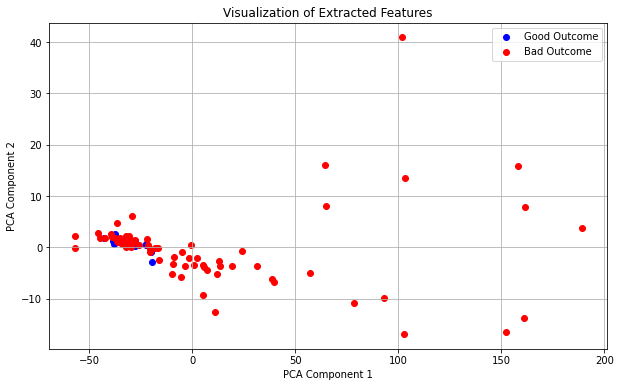

In [8]:
# 提取嵌入特征
features, labels = extract_features(model, test_dataloader)
print(f"Extracted Features Shape: {features.shape}, Labels Shape: {labels.shape}")

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


# 使用 PCA 将嵌入特征降维到 2D 以进行可视化
def visualize_features(features, labels):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    # 将 Good Outcome 和 Bad Outcome 分开
    good_outcome = reduced_features[labels == 1]
    bad_outcome = reduced_features[labels == 0]

    # 绘制二维散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(good_outcome[:, 0], good_outcome[:, 1], color='blue', label='Good Outcome')
    plt.scatter(bad_outcome[:, 0], bad_outcome[:, 1], color='red', label='Bad Outcome')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Visualization of Extracted Features')
    plt.legend()
    plt.grid(True)
    plt.show()

# 调用可视化函数
visualize_features(features, labels)

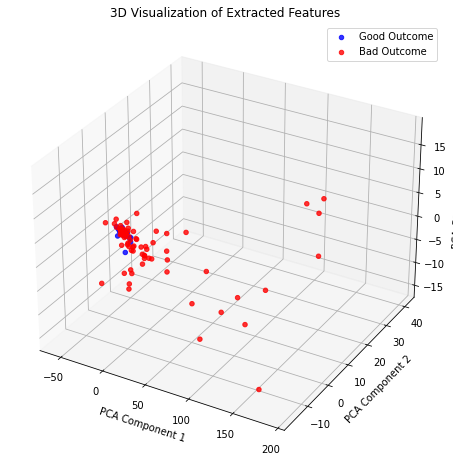

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# 使用 PCA 将嵌入特征降维到 3D 以进行可视化
def visualize_features_3d(features, labels):
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(features)

    # 将 Good Outcome 和 Bad Outcome 分开
    good_outcome = reduced_features[labels == 1]
    bad_outcome = reduced_features[labels == 0]

    # 绘制三维散点图
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(good_outcome[:, 0], good_outcome[:, 1], good_outcome[:, 2], color='blue', label='Good Outcome', alpha=0.8)
    ax.scatter(bad_outcome[:, 0], bad_outcome[:, 1], bad_outcome[:, 2], color='red', label='Bad Outcome', alpha=0.8)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('3D Visualization of Extracted Features')
    ax.legend()
    plt.show()

# 调用可视化函数
visualize_features_3d(features, labels)